# Exploration of decision boundaries from classifier models

This Jupyter notebook loads a precomputed randomly distributed set of synthetic features (lune_lat, lune_lon) to make predictions using each of the 10 classifier models loaded from saved files from the previous Jupyter notebook (ichinose-capstone-version4.ipynb).  The trained models from the previous notebook are used to predict both class membership and class probabilities.  These values are output to a csv file and loaded by an external plotting routine to plot the decision boundaries for comparisons.   

Visualizing the decision boundaries is important for inspecting the models ability to make logical and physically correct predictions in the 2 parameter (lune_lat, lune_lon) spherical space.  For instance, the class membership at the north pole (90,0) must classify as "ex" or explosion and at the south pole (-90,0) must classify as "co" or collapse (mining or cavity).  Also, the origin (0,0) must classify as a high probability (e.g., ~ 100%) earthquake where there is the highest density of training data.  These lune_lat and lune_lon for the 3 conanical sources must retain the physically correct class memberships. Since there is much fewer "ex" and "co" data points, then the probabilities may not be high confidence as "eq". 

We expect the SVM, QDA, GPC, GNB, LGR, and MLP estimators to produce decision boundaries with simple smooth curved boundries between the classes with gradiational class probabilities. Most of these methods are parameteriezed and with just 2 input independent variables, it is expected the models will not be too complex. In contrast we expect DTC, RFC, and KNN decision boundaries to be more complex and difficult to explain in terms of the two parameter input space. 

At the end we added the decision boundaries computed from a 2-layer nueral network (NN) classifier. The first was a test to examine if the NN could be trained based on MT itself (i.e.,) mxx, myy, mzz, mxy, mxz, and myz.  The second attempt was based on just the lune_lat and lune_lon. We found as expected that the NN trained on lune_lat and lune_lon, resulted in similar classifier decsion boundaries as MLP and SVM . 

We were surprised that even with limited training data, that the NN could be trained from 6 independent variables to somewhat resemble the results obtained with using just 2 independent variables (ex on top, co below and eqs in the middle).  However the class probabilities are highly variable "rough" with no sharp decision boundaries.  Perhaps more training data and more complex NN models are required for NN to learn the dimensionality reduction and nonlinear transformation from eigenvalue to spherical projection. Further work was beyond the scope of this study.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, label_binarize
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import warnings
from sklearn import set_config
set_config(display="diagram")
warnings.filterwarnings('ignore')
import pickle

The function below is for the sklearn classification estimators (not tensorflow.keras) and computes the multiclass memberships and multiclass probabilities based on sklearn's predict() and predict_proba() python class methods.  The function takes the classifiers object instance (clf) and string list of class labels as input.  It also takes a Pandas DataFrame X as input with columns X["lune_lat"] and X["lune_lon"].  The numerical class membership, class label, and class probabilities are appended to the DataFrame X and returned as a new instance. 

#### update 3/12. Upon closer inspection, we found that the method clf.predict() does not return the class label consistent with the class probabilities.  We instead used the argmax function   (index with maximum probability) to determine the correct predicted label. We then reran the script and remade the plots. 

In [2]:
#
# load the classifier estimator and do predicts 
# (both class type and individual class probabilities)
# from a list of observed/measured or simulated features
# returns original dataframe with added columns: 
#      columns: class, etype_pred, prob_eq, prob_ex, prob_co 
#
def physics_test_predict( clf, X, class_labels ):
    ##
    ## this does not work? returns class memberships inconsistent with probabilities
    # idx = clf.predict(X)
    ##
    probs = clf.predict_proba(X)

    nrows = len(X_synth)
    etype = np.empty(nrows, dtype=object)   
    class_membership_number = np.empty(nrows, dtype=int)   

    ## this works better
    ##
    for i in range(nrows):
        idx = np.argmax(probs[i])
        etype[i] = class_labels[idx]
        class_membership_number[i] = idx
    
    X['class'] = class_membership_number[:]
    X['etype_pred'] = etype[:]
    X['prob_eq'] = probs[:,0]
    X['prob_ex'] = probs[:,1]
    X['prob_co'] = probs[:,2]

    return(X)

We loaded a sest of 50,005 precomputed lune_lon, and lune_lat features.  These were uniformly distributed on an eigenvalue sphere.  The values were simulated using a external code written in C.  


In [3]:
df = pd.read_csv( "data/lune2mt.csv")    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   lune_lon  50005 non-null  float64
 1   lune_lat  50005 non-null  float64
 2   pvr       50005 non-null  float64
 3   pdc       50005 non-null  float64
 4   pclvd     50005 non-null  float64
 5   piso      50005 non-null  float64
 6   Mo        50005 non-null  float64
 7   mxx       50005 non-null  float64
 8   myy       50005 non-null  float64
 9   mzz       50005 non-null  float64
 10  mxy       50005 non-null  float64
 11  mxz       50005 non-null  float64
 12  myz       50005 non-null  float64
 13  eig1      50005 non-null  float64
 14  eig2      50005 non-null  float64
 15  eig3      50005 non-null  float64
dtypes: float64(16)
memory usage: 6.1 MB


The numbers were randomly generated for a spherical uniform distribution

In [4]:
# df[[ 'mxx', 'myy', 'mzz', 'mxy', 'mxz', 'myz' ]].describe()
# df[['eig1', 'eig2', 'eig3']].describe()
df[['lune_lat', 'lune_lon']].describe()

,lune_lat,lune_lon
count,50005.000000,50005.000000
mean,-0.043371,-0.041304
std,39.080786,17.352403
min,-90.000000,-30.000000
25%,-29.924000,-15.078000
50%,0.076000,0.006000
75%,30.061000,14.948000
max,90.000000,30.000000


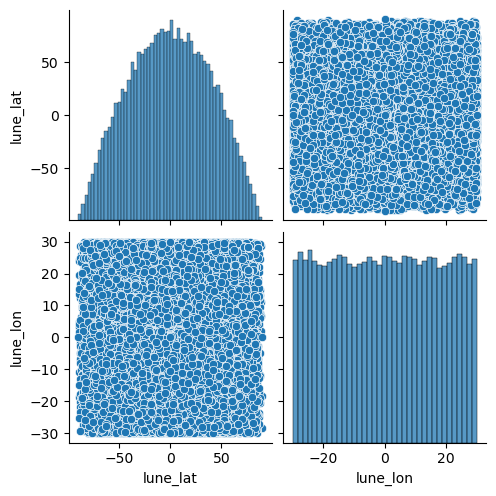

In [5]:
## sns.pairplot( data = df[['eig1', 'eig2', 'eig3']] )
## sns.pairplot( data = df[['mxx', 'myy', 'mzz', 'mxy', 'mxz', 'myz']] )
sns.pairplot( data = df[['lune_lat', 'lune_lon']] )

We are going to append predictions to the original dataframe-X using all the classifiers/estimators and the write them out to be plotted on a sphere to see where the decision lines are placed.

In [6]:
class_labels = ['eq', 'ex', 'co']

# Support Vector Classifier

In [7]:
filename = 'output/svc_grid.sav'
load_svc_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_svc_grid, X_synth, class_labels )
X_new.to_csv('output/svc.csv', index=False)

![Lune plot for SVC](output/svc.lune.jpg)

SVM has the best performance in terms of best recall and an acceptable precision.  The boundaries also are correct for the conanical sources (+/i ISO at poles and DC at origin) and simple to explain.  

# Decision Tree Classifer

In [8]:
filename = 'output/dtc_grid.sav'
load_dtc_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_dtc_grid, X_synth, class_labels )
X_new.to_csv('output/dtc.csv', index=False)

![Lune plot for DTC](output/dtc.lune.jpg)

DTC has the 2nd best performance in terms of best recall and an acceptable precision.  However, the boundaries are complex yet still correct for the conanical sources (+/i ISO at poles and DC at origin). Based on the complex boundaries especially the notch and region of co class next to ex boundary, this would not be a good predictor.  We will check later with boosting and bagging below to see if the DTC estimator could be improved with a small training dataset.

# KnearestneighborsClassifier 

In [9]:
filename = 'output/knn_grid.sav'
load_knn_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_knn_grid, X_synth, class_labels )
X_new.to_csv('output/knn.csv', index=False)

![Lune plot for KNN](output/knn.lune.jpg)

KNN does not have a very good performance in terms of recall and precision. The boundaries also are complex and not correct for the conanical sources (+/i ISO at poles and DC at origin).  The embedded region of different classes complex boundary also makes this classifer difficult to explain. 

# LogisticRegression

In [10]:
filename = 'output/lgr_grid.sav'
load_lgr_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_lgr_grid, X_synth, class_labels )
X_new.to_csv('output/lgr.csv', index=False)

![Lune plot for LGR](output/lgr.lune.jpg)

LGR has the best performance in terms of best recall but the worst score in accuracy and precision. The boundaries also are correct for the conanical sources (+/i ISO at poles and DC at origin) and simple to explain. 

# RandomForestClassifier

In [11]:
filename = 'output/rfc_grid.sav'
load_rfc_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_rfc_grid, X_synth, class_labels )
X_new.to_csv('output/rfc.csv', index=False)

![Lune plot for RFC](output/rfc.lune.jpg)

RFC has an average performance scores in terms of recall and precision. The boundaries also are correct for the conanical sources (+/i ISO at poles and DC at origin) and simple to explain and the probability distribution much less complex than DTC. RFC is an improvement over DTC. 

# GausianProcessClassifier

In [12]:
filename = 'output/gpc_grid.sav'
load_gpc_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_gpc_grid, X_synth, class_labels )
X_new.to_csv('output/gpc.csv', index=False)

![Lune plot for GPC](output/gpc.lune.jpg)

GPC has the poor performance in terms of recall but an acceptable precision score relative to other classifiers. The boundaries also are correct for the conanical sources (+/i ISO at poles and DC at origin) and simple to explain.  The main difference is in the higher latitudes.  This is where SVM and MLP tend to be better in ex recall scores. 

# Multilayer Perceptron classifier

In [13]:
filename = 'output/mlp_grid.sav'
load_mlp_grid = pickle.load(open(filename, 'rb'))
class_labels = ['eq', 'ex', 'co']
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_mlp_grid, X_synth, class_labels )
X_new.to_csv('output/mlp.csv', index=False)

![Lune plot for MLP](output/mlp.lune.jpg)

MLP had average performance in terms of recall and precision. The boundaries also are correct for the conanical sources (+/i ISO at poles and DC at origin) and simple to explain. Results very similar to SVM.

# AdaBoostClassifier

In [14]:
filename = 'output/abc_grid.sav'
load_abc_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_abc_grid, X_synth, class_labels )
X_new.to_csv('output/abc.csv', index=False)  

![Lune plot for ABC](output/abc.lune.jpg)

ABC had average performance score in recall and precision. The boundaries are not correct for the conanical source at -ISO at the south pole. The method assigns very low probabilities to collapse data, therefore has poor ability to predict collapses.  This is an odd result and perhaps requires further looking into the hyperparamter tuning.  

# GaussianNaiveBayes Classifier

In [15]:
filename = 'output/gnb_grid.sav'
load_gnb_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_gnb_grid, X_synth, class_labels )
X_new.to_csv('output/gnb.csv', index=False)

![Lune plot for GNB](output/gnb.lune.jpg)

GNB had average performance in terms of recall and precision. The boundaries also are correct for the conanical sources (+/i ISO at poles and DC at origin) and simple to explain.

# QuadraticDiscriminantAnalysis

In [16]:
filename = 'output/qda_grid.sav'
load_qda_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_qda_grid, X_synth, class_labels )
X_new.to_csv('output/qda.csv', index=False)

![Lune plot for QDA](output/qda.lune.jpg)

QDA had average performance in terms of recall and precision. The boundaries also are correct for the conanical sources (+/i ISO at poles and DC at origin) and simple to explain. The resutls are very similar to GNB. 

# Comparison with NN

The results from NN (from seperate Jupyter notebook) are compare below.

We added the decision boundaries computed from a 2-layer nueral network (NN) classifier. The first was a test to examine if the NN could be trained based on MT itself (i.e.,) mxx, myy, mzz, mxy, mxz, and myz. The second attempt was based on just the lune_lat and lune_lon. 

### Artificial Neural Network Predictions from Synthetic Dataset (trained with moment tensor)

![Lune plot for ANN](output/nn.mt.jpg)

We were surprised that even with limited training data, that the NN could be trained from 6 independent variables to somewhat resemble the results obtained with using just 2 independent variables (ex on top, co below and eqs in the middle). However the class probabilities are highly variable "rough" with no sharp decision boundaries. Perhaps more training data and more complex NN models are required for NN to learn the dimensionality reduction and nonlinear transformation from eigenvalue to spherical projection. Further work was beyond the scope of this study.

### Artificial Neural Network Predictions from Synthetic Dataset (trained with lune_lat and lune_lon)

![Lune plot for ANN](output/nn.lune.lune.jpg)

We found as expected that the NN trained on lune_lat and lune_lon, resulted in similar classifier decsion boundaries as MLP and SVM .